# Parallelism in Python


Original Author: J.R. Johansson (jrjohansson at gmail.com)

The latest version of this [IPython notebook](http://ipython.org/notebook.html) lecture is available at [http://github.com/jrjohansson/scientific-python-lectures](http://github.com/jrjohansson/scientific-python-lectures).

The other notebooks in this lecture series are indexed at [http://jrjohansson.github.io](http://jrjohansson.github.io).

# Table of Contents

[For the Georgia Tech Student](#for-the-georgia-tech-student)

[What is parallelism?](#what-is-parallelism)

- [What isn't parallelism](#what-isnt-parallelism)

- [Amdahl's Law](#amdahls-law)

- [Bringing order to parallelism](#bringing-order-to-parallelism)

- [Sharing is caring](#sharing-is-caring)

[HPC Tools](#hpc-tools)

- [multiprocessing](#multiprocessing)

- [ipyparallel](#ipyparallel)

- [MPI](#mpi)

- [OpenMP](#openmp)

- [OpenCL](#opencl)

# For the Georgia Tech Student

There are classes at GT that cover concepts that are useful for understanding parallel programming. They are listed in this section. For those not at GT, the title is included so you can probably find an equivalent.

__CS 2110 - Computer Organization and Programming__
- Covers everything from transisters to C.

__CS 2200 - An Introduction to Computer Systems and Networks__
- Goes into some detail about computer architecture and concurrency.

__ECE 3058 - Architecture, Systems, Concurrency and Energy in Computation__
- Introduces students to computer architecture such as the core, memory hierarchy, and the I/O subsystem.

__ECE 4100/6100 / CS 4290/6290 - Advanced Computer Organization__
- Covers techiniques used in computer architecture to improve performance (ex. branch prediction, caches...).

__CX 4220 / CSE 6220 - Introduction to High Performance Computing__
- Covers various parallel algorithms.

*Details on availability and prerequisites can be found on OSCAR.

#### VIPs that involved HPC

[Team Phoenix-Cluster Competition Team (HPC)](https://www.vip.gatech.edu/teams/vwp)

#  What is parallelism?

Before we get into the tools that enable parallelism, let's look at what it is and what sorts of parallelism are out there.

Note: [this](https://hpc.llnl.gov/documentation/tutorials/introduction-parallel-computing-tutorial) is a pretty good resource for an image oriented explaination of parallelism, but it will go into much more detail than we will(getting to the architectural level you don't need to immediately know to try out parallel programming).

### What isn't parallelism

Any code that isn't parallel is considered serial. That's the code you're making in most computer science classes. Classes like CS 2110, CS 2200 (maybe CS 2340 if you get fancy with your project) include some threading, but that's only one of many ways to parallelize your code.

Serial programs only execute one line at a time at only one place at a time. No multitasking going on here. While that may be fine if you're trying to print hello world once, but what if you want to print it 10 times and your computer is extremely slow?

In [1]:
# load in tools for this section
from multiprocessing.pool import ThreadPool as Pool # change this to pool once finished developing for the colab
import time

In [ ]:
for i in range(10):
  time.sleep(1);
  print("%d: hello world" % i)

That was really slow. Now imagine doing that 100 or 1000 times. Apply this logic to problems that take in thousands of inputs, and you're looking at a really slow program that could take weeks to run.

That's where parallelism comes in. With some tricks and division of labor, that program could run in an hour.

Continuing from the previous example, this can be parallelized like so:

In [ ]:
def say_hello(num):
  time.sleep(1)
  print("hello, I am number %d" % num)

num_processes = 10
num_tasks = 10
with Pool(processes=num_processes) as pool:
  pool.map(say_hello, range(num_tasks))

That went much faster. You might also notice that the numbers are no longer in order. This is a side effect of parallelism. When you split up tasks into separate processes, each process is now focused on executing that task. It doesn't know nor care about what the other processes are doing (you can change this with techniques discussed later). Order is no longer guaranteed, and this factors into how scientists design algorithms in parallel.

What did that program do that made it so much faster?

First, we defined a Pool of ten processes. In our favorite analogy of the final exam, we've essentially now got ten students working on the same exam. Then we told the pool to map the function __say_hello__ to the integers between 0 and 10. This is equivalent to students deciding who should work on which question. And once the tasks are assigned, the processes are off to complete their work. Due to the fact we are printing to a single terminal, all the results are printed there. Since there may be minute differences in timing, processes finish at different times, resulting in different orders every time(and sometimes odd formatting). For the final exam, it's like if the students stacked their answers in one pile in order of completion with no regard to order, leaving the professor to sort out the work later in serial fashion.

You may notice that the program maps one task to each process. This is possible because we have an equal number of tasks and processes. Try changing the __num_processes__ and __num_tasks__ values and see how that affects how long it takes the program to run.

### Amdahl's Law

If you toyed around with the previous example, you might noticed that the runtimes change. Not just that, you might notice that as you add more processors, the time decreases less and less, to the point there is no decrease in time (when __num_processes__ > __num_tasks__).

This phenomenon can be summated by Amdahl's law, which notes that the max speedup gained reducing the time spent is parallel is limited by the sequential portion of the code. In the previous example, the sequential part was negligable, but what if the code was written like so:

In [ ]:
num_processes = 10
num_tasks = 10
time.sleep(5)
with Pool(processes=num_processes) as pool:
  pool.map(say_hello, range(num_tasks))

Now, if you adjust __num_processes__ and __num_tasks__, you might notice that no matter what, the function takes at least 6 seconds. Let's get into the math of it.

Amdahl's Law isn't just there to tell you you can't get infinite speed up with the magic of parallelization: it's also an equation that can tell you how much you reduced your program's running time.

The equation can be described as so:

$$S = \frac{1}{(1-p) + \frac{p}{N}}$$

where p is the fraction of the code that is parallelizable and N is the speedup resulted from parallel magic (in our example it is essentially the number of processes, __num_processes__)

Now, let's apply it to our case.

With the addition of __sleep(5)__, the runtime of serial version of the code would take 15 seconds (5s + 1s per number).

The part of the code that we can parallelize is the for loop, which took 10s to run. So _p_ is calculated as so:

$$p = \frac{10}{15} = \frac{2}{3} = 0.666...$$ 

The next part to calculate is _N_. In our case _N_ is simply __num_processes__. Let's say _N_ is 5. Plugging _p_ and _N_ into the function, you get

$$S = \frac{1}{(1-0.6666) + \frac{0.6666}{5}} = 2\frac{1}{7}$$

When you run the code with __num_processes__ as 5 and __num_tasks__ as 10, this section takes 2s. With the initial 5s from the __sleep()__ function, that adds up to 7s. The initial function took 15s. Amdahl's law stated that with 5 processes, the speed up would be just around 2, and if you divide 15 by 7, you get the same value.

*Note our example has a clear bottom, which is when each process gets 1 task. And so Amdahl's law might act funny as you add more processors. After all, how can you further divide up a single task?

Below is an image of Amdahl's law visualized.

![Amdahl's Law visualized](amdahls_law.png)

#### __Exercise__: Try calculating the speed up for when __num_processes__ is 10. 3? 2? Infinity?

Now that we've looked at the limits of parallelization/optimization, let's get back to the hello world program and see how we can get it to print in order.

### Bringing order to parallelism

In the previous section you parallelized a simple hello world program. Then you looked at the limitations of parallelization. While it would print "hello world" faster, it didn't do it in order. Luckily, there are ways you can control the order processors finish their work. You can also make them stop at the same point. 

But note that just because you can doesn't mean you should. The more you try to control when programs stop and keep them in order, the more overhead there is for you and the less the computers are computing. For certain problems, like a 2D simulation, it's unavoidable. 

Let's take a quick look at threads and processes and their differences.

Threads and processes are very similar in if you have a group of them, they can each execute their own code at the same time and independently of each other(i.e. they have their own call stack), but that's about it for similarities.

Processes can spawn threads. Threads cannot spawn processes (maybe other threads, but that's not recommended). If you wanted to, you could do "double" parallelism, where you split work up between processors/processes, and within each one have the work split up between threads.

Processes have their own memory and data. Threads are able to share memory and data between each other. Because of this difference, programming with threads and with processes require different techniques.

In the following sections we will discuss how you can synchronize your programs and share data between them.

### Synchronization

#### Barriers

Processes have no connection with each other. They have their own resources and call stack. And so, if they want to stop at the same place, each of them must call the same function. In MPI, it's referred to as __MPI_Barrier__. The function takes in a [communicator](https://mpitutorial.com/tutorials/introduction-to-groups-and-communicators/). When the function is called, the processor is blocked at that point until every process in the communicator calls the function as well. This guarantees that once this function is lifted, your processes are in the same place.

Threads can also use barriers to synchronize. Below is an example with threads.

In [ ]:
from threading import Barrier, Thread
from time import sleep, ctime

num_threads = 4
b = Barrier(4) # set up barrier. This barrier will only let up if 4 threads call b.wait()

def task(num):
    sleep(num)
    print("Thread %d has reached the barrier at time %s." % (num, ctime()))
    b.wait()
    print("Thread %d has gotten past the barrier at time %s." % (num, ctime()))

threads = []
for i in range(num_threads):
    threads.append(Thread(target=task, args=(i,)))
    threads[-1].start() # start the thread in the back of the array

# bring all the threads together, effectively ending them
for thread in threads:
    thread.join()

# modified from https://www.tutorialspoint.com/barrier-objects-in-python

Try adjusting __num_threads__(3, 8, 7 are some nice numbers) and see what happens. Why does the program stall when you set __num_threads__ to 3 or 7?

#### Join

In the barrier example you might have noticed that at the end of the code, __threads__ joins all the threads together. __join()__ is used by the main program (in this case through __threads__) to stall the main program until the specific thread is finished execution. So if that thread ends up in an infinite loop and __join()__ is called, the program will never end.

In a sense, it kills off the threads(they can always be started with __start()__), but if you start respawning threads after joining all the threads, you'll be starting at the same point of execution. __join()__ is good for ensuring that a thread is finished by a certain point before the main program does more work.

![thread-diagram](thread-diagram.png)

[Source](https://www.cs.csustan.edu/~john/Classes/CS3750/Notes/Chap04/04_Threads.html) - Also features a lot of details about threads

Note: __fork()__ is often the function used to create a thread in other threading frameworks

### Sharing is caring

In previous examples we had programs that had processes execute their task without the help/data of any other program. These sort of problems are known as embarrassingly parallel. They're easy to parallelize (simple pooling or any way of creating threads of execution). Unfortunately, most problems are not like that. Often times problems need shared variables to be able to track booleans. Or a process might need data from another process.

#### Shared memory

Because threads are part of the same process, they share the same global variables and [heap memory](https://stackoverflow.com/questions/79923/what-and-where-are-the-stack-and-heap)(if you don't know what this is, you don't need to for this tutorial). But, like siblings, if two threads want the same variable at the same time, conflict ensues. If multiple threads are trying to edit or read the same variable, then wonky behavior can occur. This is a data race. We don't like those.

#### Locks

Locks are a way to ensure that a section of code is access by only one thread. Common uses include writing to a shared variable, such as updating a state. Another thing may be accesses to data to prevent data races when reading and writing.

In [ ]:
from threading import Thread, Lock
import time

lock = Lock()

attendance = ""

def task(name):
    global attendance

    with lock:
        time.sleep(1)
        attendance += "%s, " % name

    print("%s is done their task" % name)

num_threads = 4
threads = []
for i in range(num_threads):
    threads.append(Thread(target=task, args=(i,)))
    threads[-1].start() # start the thread in the back of the array

# bring all the threads together, effectively ending them
for thread in threads:
    thread.join()

print(attendance)

As you can see above, the lock forced threads to wait their turn until they could get the lock. Without the lock, the threads would all try to write to __attendance__ at the same time and chaos would ensue.

The above was only one kind of lock. There are many, many other kinds of locks (ex. spinlock, semaphore) that we will not go into. You'll learn more about them in CS 2200 and CS 3210.

Threads need locks to prevent conflicts. Processors on the other hand have no conflict. They cannot share data unless you specify it with communication.

#### Communication

Processes don't share data, so they have no idea what other processes have. However, through communication, data can be passed between processors.

For many machines, they use the message passing interface (MPI) to communicate with each other. Luckily, MPI is heavy in communication so examples can be found [here](#mpi). We will discuss what various communication primatives do in this section.

# HPC Tools 

In [56]:
# Load in libraries to plots graph in preparation for the next few sections
%matplotlib inline
import matplotlib.pyplot as plt

## multiprocessing

Python has a built-in process-based library for concurrent computing, called `multiprocessing`. Further documentation can be found [here](https://docs.python.org/3/library/multiprocessing.html)

The multiprocessing module is versatile and allows you to program in thread-like and message passing model ways.

### Pool
Pool is a simple way to create a group of processes that you can offload tasks to.

In [24]:
from multiprocessing.pool import ThreadPool as Pool
import os
import time
import numpy

In [3]:
def task(args):
    print("PID =", os.getpid(), ", args =", args)

    return os.getpid(), args

In [ ]:
task("test")

In [4]:
pool = Pool(processes=4)

In [5]:
result = pool.map(task, [1, 2, 3, 4, 5, 6, 7, 8])

PID = 43504 , args = 1
PID = 43504 , args = 2
PID = 43504 , args = 3
PID = 43504 , args = 4
PID = 43504 , args = 5
PID = 43504 , args = 6
PID = 43504 , args = 7
PID = 43504 , args = 8


The multiprocessing package is very useful for highly parallel tasks that do not need to communicate with each other, other than when sending the initial data to the pool of processes and when and collecting the results.

#### Vector Summation Exercise

In the multiprocessing pool example, only one argument was passed into each task. How might you go about passing in two separate values(or a group of values as one)? Try your hand at it with a parallel vector summation.

In [7]:
vector1 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
vector2 = [9, 8, 7, 6, 5, 4, 3, 2, 1]

def task(args):
    # return val1 + val2
    return 1

result = pool.map(task, [0]) # pool comes from previous cells as in notebooks, variables declared in other cells remain persistent from that point onwards (until you reset the notebook)

result # result should be [10, 10, 10, 10, 10, 10, 10, 10, 10]

[1]

### multiprocessing starmap()

In the above exercise we made you pass in multiple arguments without having task() specify multiple arguments. If you want the task function to explicitly take in multiple arguments, you can use the starmap() function, which will take in an [iterable](https://python.cogsci.nl/basic/iterables/)(ess. lists, dicts, anything you might use be able to use a for-loop to loop through), but expect that the elements will be unpacked as arguments. 

In [8]:
zip_vectors = zip(vector1, vector2) # preparing an iterable for starmap 

In [16]:
def task(arg1, arg2):
    return arg1 + arg2

In [17]:
result = pool.starmap(task, zip_vectors)

In [13]:
result

[10, 10, 10, 10, 10, 10, 10, 10, 10]

#### Starmap exercise

To practice using the starmap(), try adding together three vectors at once.

In [ ]:
vector1 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
vector2 = [9, 8, 7, 6, 5, 4, 3, 2, 1]
vector3 = [1, 2, 3, 4, 5, 6, 7, 8, 9]

def task(nothing):
    # return val1 + val2 + val3
    return 1

result = pool.starmap(task, 0)

result # result should be [11, 12, 13, 14, 15, 16, 17, 18, 19]

#### Further readings

- https://docs.python.org/3/library/multiprocessing.html

- https://superfastpython.com/multiprocessing-in-python/

## ipyparallel

IPython includes a very interesting and versatile parallel computing environment, which is very easy to use. It builds on the concept of ipython engines and controllers, that one can connect to and submit tasks to. To get started using this framework for parallel computing, one first have to start up an IPython cluster of engines. The easiest way to do this is to use the `ipcluster` command,

    $ ipcluster start -n 4

Or, alternatively, from the "Clusters" tab on the IPython notebook dashboard page. This will start 4 IPython engines on the current host, which is useful for multicore systems. It is also possible to setup IPython clusters that spans over many nodes in a computing cluster. For more information about possible use cases, see the official [documentation](https://ipyparallel.readthedocs.io/en/latest/).

To use the IPython cluster in our Python programs or notebooks, we start by creating an instance of `ipyparallel.Cluster`:

In [40]:
import ipyparallel as ipp
import numpy

In [41]:
cluster = ipp.Cluster()

By calling __connect_client()__ we can get the set of ids for the IPython engines in the cluster.

In [ ]:
engine_set_id = await cluster.start_cluster(n=4) # ess creates 4 processes that can do work

rc = await cluster.connect_client()
rc.wait_for_engines(4)
rc.ids

Each of these engines are ready to execute tasks. We can selectively run code on individual engines:

In [44]:
def getpid():
    """ return the unique ID of the current process """
    import os
    return os.getpid()

In [12]:
# first try it on the notebook process
getpid()

31256

In [15]:
# run it on one of the engines
rc[0].apply_sync(getpid)

37440

In [45]:
# run it on ALL of the engines at the same time
rc[:].apply_sync(getpid)

[25500, 35608, 12272, 8200]

We can use this cluster of IPython engines to execute tasks in parallel. The easiest way to dispatch a function to different engines is to define the function with the decorator:

    @view.parallel(block=True)

Here, `view` is supposed to be the engine pool which we want to dispatch the function (task). Once our function is defined this way we can dispatch it to the engine using the `map` method in the resulting class (in Python, a decorator is a language construct which automatically wraps the function into another function or a class).

To see how all this works, lets look at an example:

In [50]:
dview = rc[:]

In [51]:
@dview.parallel(block=True)
def dummy_task(delay):
    """ a dummy task that takes 'delay' seconds to finish """
    import os, time

    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()

    return [pid, t0, t1]

In [22]:
# generate random delay times for dummy tasks
delay_times = numpy.random.rand(4)

Now, to map the function `dummy_task` to the random delay time data, we use the `map` method in `dummy_task`:

In [ ]:
dummy_task.map(delay_times)

Let's do the same thing again with many more tasks and visualize how these tasks are executed on different IPython engines:

In [53]:
def visualize_tasks(results):
    res = numpy.array(results)
    fig, ax = plt.subplots(figsize=(10, res.shape[1]))

    yticks = []
    yticklabels = []
    tmin = min(res[:,1])
    for n, pid in enumerate(numpy.unique(res[:,0])):
        yticks.append(n)
        yticklabels.append("%d" % pid)
        for m in numpy.where(res[:,0] == pid)[0]:
            ax.add_patch(plt.Rectangle((res[m,1] - tmin, n-0.25),
                         res[m,2] - res[m,1], 0.5, color="green", alpha=0.5))

    ax.set_ylim(-.5, n+.5)
    ax.set_xlim(0, max(res[:,2]) - tmin + 0.)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("PID")
    ax.set_xlabel("seconds")

In [71]:
delay_times = numpy.random.rand(64)

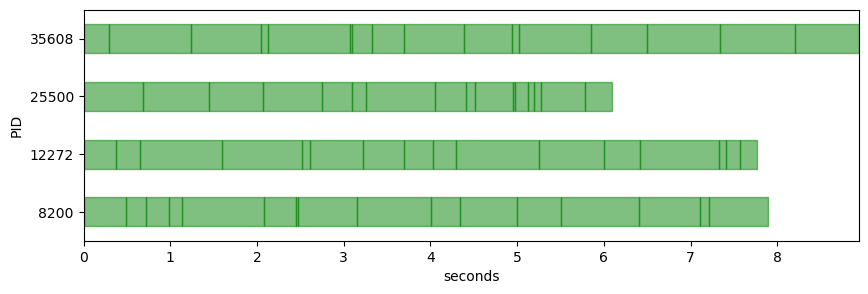

In [61]:
result = dummy_task.map(delay_times)
visualize_tasks(result)

That's a nice and easy parallelization! We can see that we utilize all four engines quite well.

But one short coming so far is that the tasks are not load balanced, so one engine might be idle while others still have more tasks to work on.

However, the IPython parallel environment provides a number of alternative "views" of the engine cluster, and there is a view that provides load balancing as well (above we have used the "direct view", which is why we called it "dview").

To obtain a load balanced view we simply use the `load_balanced_view` method in the engine cluster client instance `cli`:

In [58]:
lbview = rc.load_balanced_view()

In [69]:
@lbview.parallel(block=True)
def dummy_task_load_balanced(delay):
    """ a dummy task that takes 'delay' seconds to finish """
    import os, time

    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()

    return [pid, t0, t1]

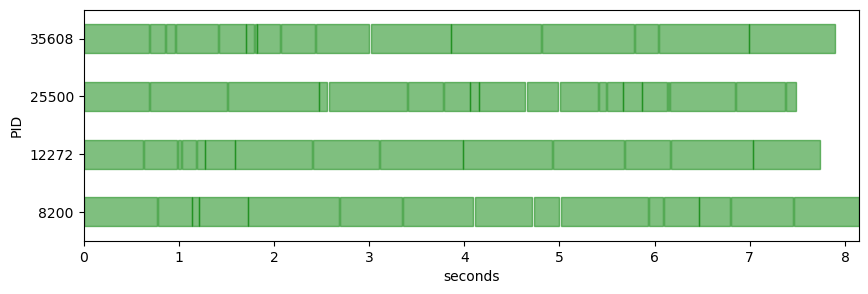

In [70]:
result = dummy_task_load_balanced.map(delay_times) # maps the tasks to the generated delay times
visualize_tasks(result)

In the example above we can see that the engine cluster is a bit more efficiently used, and the time to completion is shorter than in the previous example.

### Exercises

Taking from the above, we've created a template for you to create a task and visualize the timings. In fact, you can duplicate the code and compare the distribution of tasks with and without load balancing.

Potential exercises:
- summation of varying amounts of numbers
- calculate if a random number is prime (widen the range for effect)
- calculate the GCD of various numbers with the Euclidean algorithm


In [81]:
@lbview.parallel(block=True)
def task_lb(delay):
    import time, os

    t0 = time.time()
    # implement something you'd like to measure the time of
    pid = os.getpid()
    t1 = time.time()

    return [pid, t0, t1]

In [82]:
@dview.parallel(block=True)
def task(delay):
    import time, os

    t0 = time.time()
    # implement something you'd like to measure the time of
    pid = os.getpid()
    t1 = time.time()

    return [pid, t0, t1]

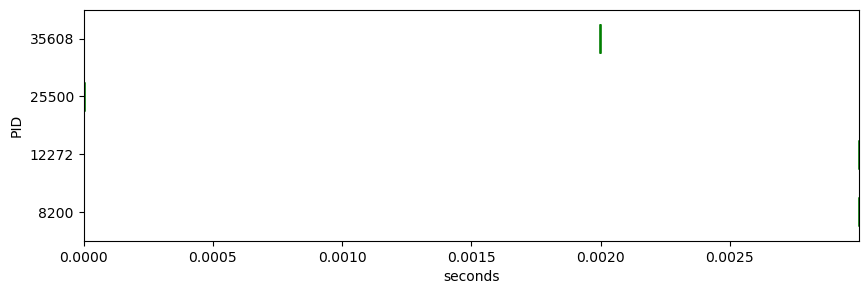

In [79]:
result = task.map(delay_times)
visualize_tasks(result)

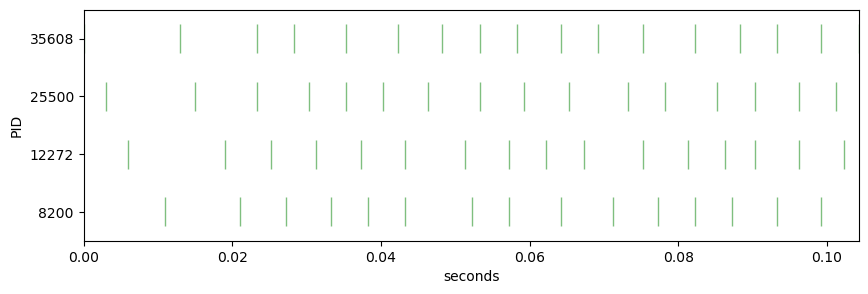

In [83]:
result = task_lb.map(delay_times) 
visualize_tasks(result)

## MPI

In [ ]:
# run if you get an error saying mpi4py can't be found
!pip install mpi4py

When more communication between processes is required, sophisticated solutions such as MPI and OpenMP are often needed. MPI is process based parallel processing library/protocol, and can be used in Python programs through the `mpi4py` package:

http://mpi4py.scipy.org/

To use the `mpi4py` package we include `MPI` from `mpi4py`:

    from mpi4py import MPI

A MPI python program must be started using the `mpiexec -n N` command, where `N` is the number of processes that should be included in the process group.

Note that the IPython parallel enviroment also has support for MPI, but to begin with we will use `mpi4py` and the `mpiexec` in the follow examples.

### Example 1

In [ ]:
%%file mpitest.py

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
   data = [1.0, 2.0, 3.0, 4.0]
   comm.send(data, dest=1, tag=11)
elif rank == 1:
   data = comm.recv(source=0, tag=11)

print("rank: %d, data: %s" % (rank, data))

In [ ]:
!mpiexec -n 2 python mpitest.py

### Example 2

Send a numpy array from one process to another:

In [61]:
%%file mpi-numpy-array.py

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
   data = numpy.random.rand(10)
   comm.Send(data, dest=1, tag=13)
elif rank == 1:
   data = numpy.empty(10, dtype=numpy.float64)
   comm.Recv(data, source=0, tag=13)

print("rank: %d, data: %s" % (rank, data))

Overwriting mpi-numpy-array.py


In [ ]:
!mpiexec -n 2 python mpi-numpy-array.py

In [33]:
# prepare some random data
N = 16
A = numpy.random.rand(N, N)
numpy.save("random-matrix.npy", A)
x = numpy.random.rand(N)
numpy.save("random-vector.npy", x)

In [36]:
%%file mpi-matrix-vector.py

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
p = comm.Get_size()

def matvec(comm, A, x):
    m = int(A.shape[0] / p)
    y_part = numpy.dot(A[rank * m:(rank+1)*m], x)
    y = numpy.zeros_like(x)
    comm.Allgather([y_part,  MPI.DOUBLE], [y, MPI.DOUBLE])
    return y

A = numpy.load("random-matrix.npy")
x = numpy.load("random-vector.npy")
y_mpi = matvec(comm, A, x)

if rank == 0:
    y = numpy.dot(A, x)
    print(y_mpi)
    print("sum(y - y_mpi) = %d" % ((y - y_mpi).sum()))

Overwriting mpi-matrix-vector.py


In [ ]:
!mpiexec -n 4 python mpi-matrix-vector.py

### Example 4: Sum of the elements in a vector

In [39]:
# prepare some random data
N = 128
a = numpy.random.rand(N)
numpy.save("random-vector.npy", a)

In [42]:
%%file mpi-psum.py

from mpi4py import MPI
import numpy as np

def psum(a):
    r = MPI.COMM_WORLD.Get_rank()
    size = MPI.COMM_WORLD.Get_size()
    m = int(len(a) / size)
    locsum = np.sum(a[r*m:(r+1)*m])
    rcvBuf = np.array(0.0, 'd')
    MPI.COMM_WORLD.Allreduce([locsum, MPI.DOUBLE], [rcvBuf, MPI.DOUBLE], op=MPI.SUM)
    return rcvBuf

a = np.load("random-vector.npy")
s = psum(a)

if MPI.COMM_WORLD.Get_rank() == 0:
    print("sum = %d, numpy sum = %d" % (s, a.sum()))

Overwriting mpi-psum.py


In [43]:
!mpiexec -n 4 python mpi-psum.py

sum = 61, numpy sum = 61


### Further reading

* https://mpi4py.readthedocs.io/en/stable/

* https://github.com/mpi4py/mpi4py

* https://computing.llnl.gov/tutorials/mpi/

### Exercises

#### In-house Broadcast

In the above examples you saw MPI send and receive functions being used to send data from one processor to another. Let's extend that and create your own implementation of the broadcast function. When a processor broadcasts, it sends a piece of data for every other processor to receive.

[Broadcast](https://rookiehpc.org/mpi/docs/mpi_bcast/index.html) is unlike send and receive as it is a collective operation, which means that every processor takes part. That is to say, for this to work, every processor must call the same function. With broadcast, one of these processors will denote itself as the sender, and the rest will be receivers.

For this exercise we will keep it more simple and assume every processor will be included in the broadcast ([communicators](https://mpitutorial.com/tutorials/introduction-to-groups-and-communicators/)). The item passed in will always be a single item (so no arrays should be passed in).

For reference, here is bcast in action:

In [47]:
%%file mpi-bcast-ex.py
# the above function creates a file from this cell for later executions

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.rank

if rank == 0:
    data = {'a':1,'b':2,'c':3}
else:
    data = None

data = comm.bcast(data, root=0)
print('rank: %d, data: %s' % (rank , data))

# source: https://pythonprogramming.net/mpi-broadcast-tutorial-mpi4py/

Overwriting mpi-bcast-ex.py


In [ ]:
!mpiexec -n 4 python mpi-bcast-ex.py

Here is some template code to start off with.

Some things to consider as you create your own broadcast:

- How do you plan on getting the message to every other rank?

- How will you ensure the right send gets to the right receive(in this case, it shouldn't matter, but this is good practice)?

- The root doesn't have to be the only rank sending messages.

In [84]:
%%file mpi-bcast-exercise.py

import numpy
from mpi4py import MPI
from types import SimpleNamespace # allows you to add attributes to an object dynamically(ie no need to create a whole class template for it)

# buffer will be an object with an attribute data that can be accessed as buffer.data
buffer_obj = SimpleNamespace()

def broadcast(buffer, root):
    if root == 0:
        return 1
    else:
        return 0

# set up MPI parameters
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

# set up data
if rank == 0:
    buffer_obj.data = numpy.random.rand(4)
else:
    buffer_obj.data = numpy.empty(4, dtype=numpy.float64)

print('Before: rank: %d, data: %s' % (rank, buffer_obj.data))
broadcast(buffer_obj, rank)
print('After: rank: %d, data: %s' % (rank, buffer_obj.data))

Overwriting mpi-bcast-exercise.py


Test out your program here. If you have any errors, let us know, or check out the [documentation](https://mpi4py.readthedocs.io/en/stable/).

In [ ]:
!mpiexec -n 4 python mpi-bcast-exercise.py

To make the exercise harder, try modifying the broadcast function to pass around multiple objects at once.

Further extensions:

- Have the root broadcast an array, but have each process only receive a portion of the elements (this is a scatter).

- Do broadcast, but each round double the processors send out the message.

- Implement other collective primatives (gather, reduce)

#### Hot Potato

Taking the same template as before, we're going to create a program that plays hot potato, where a processor will have a special value, and it must be passed around one processor at a time.

This may require you to look into [non-blocking](https://stackoverflow.com/questions/10017301/mpi-blocking-vs-non-blocking) versions of send and receive. If you have any questions about this, feel free to reach out to one of us or the Discord.

In [ ]:
%%file mpi-hot-potato-exercise.py

import numpy
from mpi4py import MPI
from types import SimpleNamespace 

buffer_obj = SimpleNamespace()

def hot_potato(buffer, direction):
    # In hot potato, you will at some point receive the potato, and then you must pass it.
    # For the sake of simplicity, every processor will receive a value and pass it, this method will simulate one round of passing
    # the edge processors (0 and size - 1) will pass to each other, depending on which direction you choose to implement hot potato
    # ex: 0 -> 1 -> 2 -> 3 -> 4 -> 0 --- example of wraparound

    # The direction parameter is an extension of this exercise where you will have to enable hot potato to go in both directions

# set up MPI parameters
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
rounds = 12

# set up data
if rank == 0:
    buffer_obj.data = numpy.random.rand(1)
else:
    buffer_obj.data = numpy.empty(1, dtype=numpy.float64)

print('Before: rank: %d, data: %s' % (rank, buffer_obj.data))

for i in range(rounds):
    hot_potato(buffer_obj, rank)

print('After: rank: %d, data: %s' % (rank, buffer_obj.data))

In [ ]:
!mpiexec --oversubscribe -n 12 python mpi-hot-potato-exercise.py

## OpenMP

What about OpenMP? OpenMP is a standard and widely used thread-based parallel API that unfortunaltely is **not** useful directly in Python. The reason is that the CPython implementation use a global interpreter lock, making it impossible to simultaneously run several Python threads. Threads are therefore not useful for parallel computing in Python, unless it is only used to wrap compiled code that do the OpenMP parallelization (Numpy can do something like that).

This is clearly a limitation in the Python interpreter, and as a consequence all parallelization in Python must use processes (not threads).

However, there is a way around this that is not that painful. When calling out to compiled code the GIL is released, and it is possible to write Python-like code in Cython where we can selectively release the GIL and do OpenMP computations.

In [1]:
import multiprocessing

In [2]:
N_core = multiprocessing.cpu_count()

print("This system has %d cores" % N_core)

This system has 12 cores


Here is a simple example that shows how OpenMP can be used via cython:

In [4]:
%load_ext Cython

In [ ]:
%%cython -f -c-fopenmp --link-args=-fopenmp -c-g

# %%cython -f -c "/openmp" <- for if you are running this notebook locally on a Windows machine

cimport cython
cimport numpy
from cython.parallel import prange, parallel
cimport openmp

def cy_openmp_test():

    cdef int n, N

    # release GIL so that we can use OpenMP
    with nogil, parallel():
        N = openmp.omp_get_num_threads()
        n = openmp.omp_get_thread_num()
        with gil:
            print("Number of threads %d: thread number %d" % (N, n))

In [ ]:
cy_openmp_test()

### Example: matrix vector multiplication

In [21]:
# prepare some random data
N = 4 * N_core

M = numpy.random.rand(N, N)
x = numpy.random.rand(N)
y = numpy.zeros_like(x)

Let's first look at a simple implementation of matrix-vector multiplication in Cython:

In [ ]:
%%cython

cimport cython
cimport numpy
import numpy

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_matvec(numpy.ndarray[numpy.float64_t, ndim=2] M,
              numpy.ndarray[numpy.float64_t, ndim=1] x,
              numpy.ndarray[numpy.float64_t, ndim=1] y):

    cdef int i, j, n = len(x)

    for i from 0 <= i < n:
        for j from 0 <= j < n:
            y[i] += M[i, j] * x[j]

    return y

In [ ]:
# check that we get the same results
y = numpy.zeros_like(x)
cy_matvec(M, x, y)
numpy.dot(M, x) - y

In [24]:
%timeit numpy.dot(M, x)

1.78 µs ± 283 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [25]:
%timeit cy_matvec(M, x, y)

11.3 µs ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The Cython implementation here is a bit slower than numpy.dot, but not by much, so if we can use multiple cores with OpenMP it should be possible to beat the performance of numpy.dot.

In [ ]:
%%cython -f -c-fopenmp --link-args=-fopenmp -c-g

cimport cython
cimport numpy
from cython.parallel import parallel
cimport openmp

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_matvec_omp(numpy.ndarray[numpy.float64_t, ndim=2] M,
                  numpy.ndarray[numpy.float64_t, ndim=1] x,
                  numpy.ndarray[numpy.float64_t, ndim=1] y):

    cdef int i, j, n = len(x), N, r, m

    # release GIL, so that we can use OpenMP
    with nogil, parallel():
        N = openmp.omp_get_num_threads()
        r = openmp.omp_get_thread_num()
        m = int(n / N)

        for i from 0 <= i < m:
            for j from 0 <= j < n:
                y[r * m + i] += M[r * m + i, j] * x[j]

    return y

In [ ]:
# check that we get the same results
y = numpy.zeros_like(x)
cy_matvec_omp(M, x, y)
numpy.dot(M, x) - y

In [30]:
%timeit numpy.dot(M, x)

1.64 µs ± 302 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [31]:
%timeit cy_matvec_omp(M, x, y)

147 µs ± 34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Now, this implementation is much slower than numpy.dot for this problem size, because of overhead associated with OpenMP and threading, etc. But let's look at the how the different implementations compare with larger matrix sizes:

In [35]:
N_vec  = numpy.arange(25, 2000, 25) * N_core

In [ ]:
duration_ref = numpy.zeros(len(N_vec))
duration_cy = numpy.zeros(len(N_vec))
duration_cy_omp = numpy.zeros(len(N_vec))

for idx, N in enumerate(N_vec):

    M = numpy.random.rand(N, N)
    x = numpy.random.rand(N)
    y = numpy.zeros_like(x)

    t0 = time.time()
    numpy.dot(M, x)
    duration_ref[idx] = time.time() - t0

    t0 = time.time()
    cy_matvec(M, x, y)
    duration_cy[idx] = time.time() - t0

    t0 = time.time()
    cy_matvec_omp(M, x, y)
    duration_cy_omp[idx] = time.time() - t0

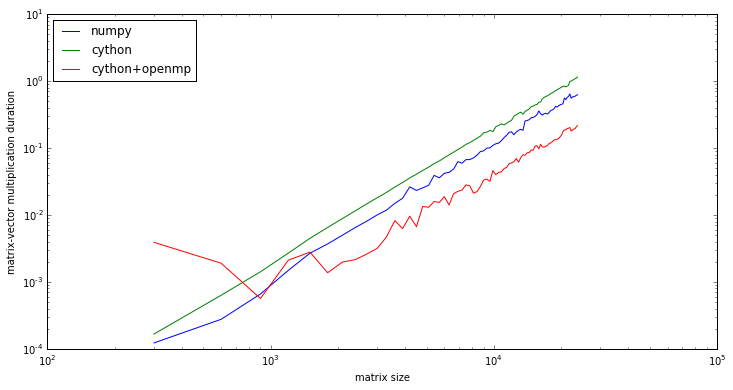

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.loglog(N_vec, duration_ref, label='numpy')
ax.loglog(N_vec, duration_cy, label='cython')
ax.loglog(N_vec, duration_cy_omp, label='cython+openmp')

ax.legend(loc=2)
ax.set_yscale("log")
ax.set_ylabel("matrix-vector multiplication duration")
ax.set_xlabel("matrix size");

For large problem sizes the the cython+OpenMP implementation is faster than numpy.dot.

With this simple implementation, the speedup for large problem sizes is about:

In [ ]:
((duration_ref / duration_cy_omp)[-10:]).mean()

3.0072232987815148

 Obviously one could do a better job with more effort, since the theoretical limit of the speed-up is:

In [ ]:
N_core

12

### Further reading

 * http://openmp.org
 * http://docs.cython.org/src/userguide/parallelism.html

## OpenCL

OpenCL is an API for heterogenous computing, for example using GPUs for numerical computations. There is a python package called `pyopencl` that allows OpenCL code to be compiled, loaded and executed on the compute units completely from within Python. This is a nice way to work with OpenCL, because the time-consuming computations should be done on the compute units in compiled code, and in this Python only server as a control language.

For this section, ensure the Colab has access to a GPU. Click on the arrow next to the RAM and Disk graphs. Then click "Change runtime type." Then select "T4 GPU" as your runtime type and complete the pop up.

In [21]:
%%file opencl-dense-mv.py

import pyopencl as cl
import numpy
import time

# problem size
n = 16000

# platform
platform_list = cl.get_platforms()
platform = platform_list[0]

# device
device_list = platform.get_devices()
device = device_list[0]

# Device information
if False:
    print("Platform name:" + platform.name)
    print("Platform version:" + platform.version)
    print("Device name:" + device.name)
    print("Device type:" + cl.device_type.to_string(device.type))
    print("Device memory: " + str(device.global_mem_size//1024//1024) + ' MB')
    print("Device max clock speed:" + str(device.max_clock_frequency) + ' MHz')
    print("Device compute units:" + str(device.max_compute_units))

# context
ctx = cl.Context([device]) # or we can use cl.create_some_context()

# command queue
queue = cl.CommandQueue(ctx)

# kernel
KERNEL_CODE = """
//
// Matrix-vector multiplication: r = m * v
//
#define N %(mat_size)d
__kernel
void dmv_cl(__global float *m, __global float *v, __global float *r)
{
    int i, gid = get_global_id(0);

    r[gid] = 0;
    for (i = 0; i < N; i++)
    {
        r[gid] += m[gid * N + i] * v[i];
    }
}
"""

kernel_params = {"mat_size": n}
program = cl.Program(ctx, KERNEL_CODE % kernel_params).build()

# data
A = numpy.random.rand(n, n)
x = numpy.random.rand(n, 1)

# host buffers
h_y = numpy.empty(numpy.shape(x)).astype(numpy.float32)
h_A = numpy.real(A).astype(numpy.float32)
h_x = numpy.real(x).astype(numpy.float32)

# device buffers
mf = cl.mem_flags
d_A_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=h_A)
d_x_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=h_x)
d_y_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=h_y.nbytes)

# execute OpenCL code
t0 = time.time()
event = program.dmv_cl(queue, h_y.shape, None, d_A_buf, d_x_buf, d_y_buf)
event.wait()
cl.enqueue_copy(queue, h_y, d_y_buf)
t1 = time.time()
print("opencl elapsed time = %f" % (t1-t0))

# Same calculation with numpy
t0 = time.time()
y = numpy.dot(h_A, h_x)
t1 = time.time()

print("numpy elapsed time = %f" % (t1-t0))

# see if the results are the same
print("max deviation = %f" % numpy.abs(y-h_y).max())

Overwriting opencl-dense-mv.py


In [ ]:
!python opencl-dense-mv.py

### Further reading

* http://mathema.tician.de/software/pyopencl

## Versions

In [ ]:
%load_ext version_information

%version_information numpy, mpi4py, Cython

Software versions
Python 3.3.2+ (default, Oct  9 2013, 14:50:09) [GCC 4.8.1]
IPython 2.0.0-b1
OS posix [linux]
numpy 1.9.0.dev-d4c7c3a
mpi4py 1.3.1
Cython 0.20.post0

Mon Mar 17 17:32:10 2014 JST